### Importing libraries

In [77]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

### Importing datasets

In [78]:
train = pd.read_csv("/Users/mac/kaggle_projects/mc-obesity-risk/playground-series-s4e2/train.csv")
test = pd.read_csv("/Users/mac/kaggle_projects/mc-obesity-risk/playground-series-s4e2/test.csv")

### EDA 

In [79]:
print(train.shape)
print(test.shape)

(20758, 18)
(13840, 17)


In [80]:
train.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [81]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [82]:
train.isna().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

### Target class distribution

In [83]:
train['NObeyesdad'].value_counts(ascending=False)

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

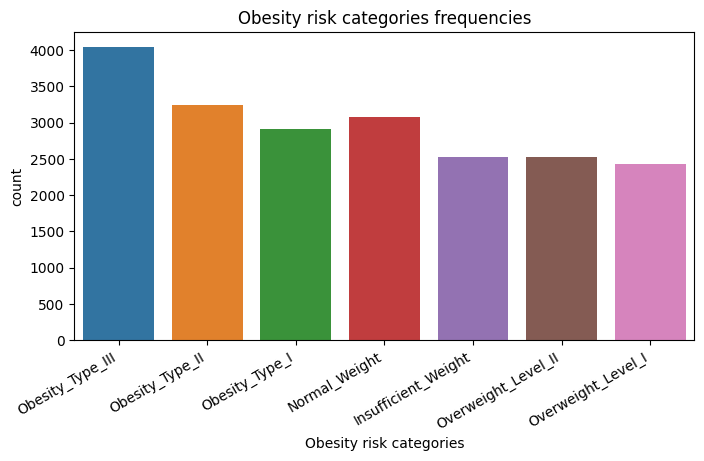

In [84]:
plt.figure(figsize = (8,4))
target_categories = [
    "Obesity_Type_III",
    "Obesity_Type_II",
    "Obesity_Type_I",
    "Normal_Weight",
    "Insufficient_Weight",
    "Overweight_Level_II",
    "Overweight_Level_I"]

ax = sns.countplot(x = 'NObeyesdad',data =train, order = target_categories)
plt.title("Obesity risk categories frequencies")
plt.xlabel("Obesity risk categories")
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 30, ha = "right")
plt.show()

### Feature Engineering

In [85]:
def adding_features(df):
    df["BMI"] = df["Weight"] / df["Height"] ** 2
    #df['Physical_Activity'] = df['FAF'] * (24 - df['TUE'])
    #df['Dietary_Habits'] = df['FCVC'] + df['NCP'] + df['CH2O']
    #df['Physical_Activity_X_BMI'] = df['Physical_Activity'] * df['BMI']
    #df['Hydration_Level'] = df['CH2O'] / df['CH2O'].sum()
    return df

In [86]:
train = adding_features(train)
test  = adding_features(test)

In [87]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151


### Categorical & Numerical Features

In [88]:
def get_variable_types(dataframe):
    continuous_vars = []
    categorical_vars = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            categorical_vars.append(column)
        else:
            continuous_vars.append(column)

    return continuous_vars, categorical_vars

continuous_vars, categorical_vars = get_variable_types(train)
categorical_vars.remove('NObeyesdad')

print("Continuous Variables:", continuous_vars)
print()
print("Categorical Variables:", categorical_vars)

Continuous Variables: ['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

Categorical Variables: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


### Encoding
OneHotEncoding for categorical features

In [89]:
train = pd.get_dummies(train, columns=categorical_vars)
test  = pd.get_dummies(test, columns=categorical_vars)

In [90]:
train.head()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,...,True,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,...,True,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,...,True,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False


### LabelEncoder
show less accuracy if applied before Scaling instead of OneHotEncoding

In [91]:
#label_encoder = LabelEncoder()

#le_encode = train[categorical_vars]
#for col in le_encode:
#    train[col]=label_encoder.fit_transform(train[col])

In [92]:
train['NObeyesdad']=train['NObeyesdad'].map({'Insufficient_Weight':0,'Normal_Weight':1,'Overweight_Level_I':2,'Overweight_Level_II':3,'Obesity_Type_I':4,'Obesity_Type_II':5,'Obesity_Type_III':6})

In [93]:
X = train.drop(['NObeyesdad'], axis=1)
y = train['NObeyesdad']

In [94]:
#xgb_model = xgb.XGBClassifier()


#xgb_model.fit(X, y)

#feature_importances = xgb_model.feature_importances_

#feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
#feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [95]:
#plt.figure(figsize=(8, 8))
#sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
#plt.title('Feature Importance')
#plt.show()

### Modelling

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [98]:
X_train

array([[-0.06754456, -1.19937194,  0.80081642, ..., -0.04254228,
        -2.01640617, -0.14928212],
       [-0.42042708, -0.2131964 ,  0.61024262, ..., -0.04254228,
         0.49593183, -0.14928212],
       [-0.17839335, -0.35749192,  1.37292791, ..., -0.04254228,
         0.49593183, -0.14928212],
       ...,
       [-0.82898403, -0.50336217, -0.92009566, ..., -0.04254228,
         0.49593183, -0.14928212],
       [-1.58408929,  0.36665004, -0.57447915, ..., -0.04254228,
         0.49593183, -0.14928212],
       [ 0.90542439,  2.45431603,  0.85049342, ..., -0.04254228,
        -2.01640617, -0.14928212]])

### XGBClassifier

In [99]:
xgb_model = xgb.XGBClassifier(n_estimators=103, random_state=42)


xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.9066


### LGBMClassifier

In [100]:
lgb_model = LGBMClassifier()


lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)

lgb_accuracy = accuracy_score(y_test, lgb_predictions)
print(f"XGBoost Accuracy: {lgb_accuracy:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 32
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
XGBoost Accuracy: 0.9046
